# Overview

Making the LLM inference process efficient is useful when you have multiple computing resources. If we have multiple GPUs, we can send a number of different prompts each to a different GPU, and then get the results back. Let's implement it in this notebook.

In [1]:
!pip install accelerate==0.25.0
!pip install diffusers==0.23.1

  Obtaining dependency information for accelerate==0.25.0 from https://files.pythonhosted.org/packages/f7/fc/c55e5a2da345c9a24aa2e1e0f60eb2ca290b6a41be82da03a6d4baec4f99/accelerate-0.25.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.24.1
    Uninstalling accelerate-0.24.1:
      Successfully uninstalled accelerate-0.24.1
  Obtaining dependency information for diffusers==0.23.1 from https://files.pythonhosted.org/packages/31/76/7a48265cb735e68bac131c74337cba06103862686151176cc6605cf2075c/diffusers-0.23.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.0 MB/s eta 0:00:00


# The Problem

Normally when doing this, users send the model to a specific device to load it from the CPU, and then move each prompt to a different device.

In [2]:
import torch
import torch.distributed as dist
from diffusers import DiffusionPipeline

pipe=DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
def run_inference(rank, world_size):
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    pipe.to(rank)

    if torch.distributed.get_rank() == 0:
        prompt = "a dog"
    elif torch.distributed.get_rank() == 1:
        prompt = "a cat"

    result = pipe(prompt).images[0]
    result.save(f"result_{rank}.png")

One will notice how we have to check the rank to know what prompt to send, which can be a bit tedious. We can also use the `Accelerator` to prepare a dataloader for such a task might also be a simple way to manage this.

# The Solution

With Accelerate, we can simplify this process by ysing the `Accelerator.split_between_processes()` context manager( which also exists in `PartialState` and `AcceleratirState`). This function will automatically split whatever data you pass to it(be it a prompt, a set of tensors, adictionary of the prior data) across all the processes (with a potential to be padded) for you to use right away.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

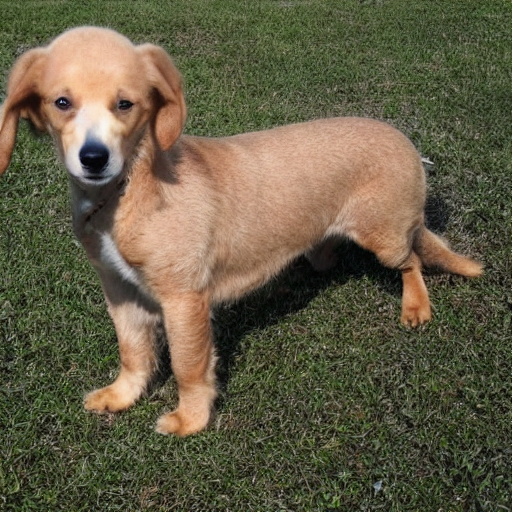

In [4]:
from accelerate import PartialState # Can also be Accelerator of AcceleratorState
from diffusers import DiffusionPipeline

def inference():
    pipe=DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
    distributed_state=PartialState()
    pipe.to(distributed_state.device)

    # Assume two processes
    with distributed_state.split_between_processes(["a dog","a cat"], apply_padding=True) as prompt:
        result_dog,result_cat=pipe(prompt).images[0], pipe(prompt).images[1]
        return result_dog, result_cat
result_dog,result_cat=inference()
result_dog

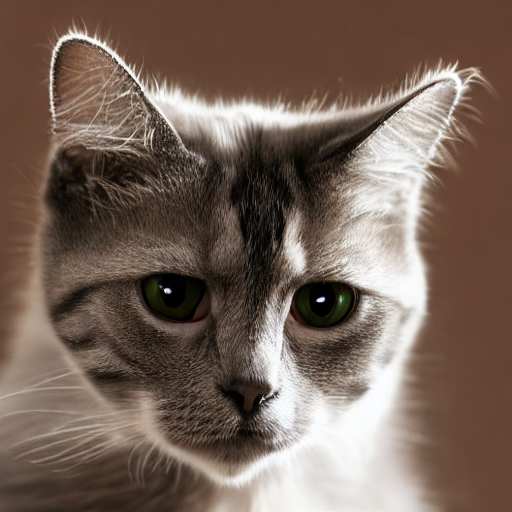

In [5]:
result_cat